In [9]:
import pandas as pd
import sqlite3

In [10]:
con = sqlite3.connect('../data/checking-logs.sqlite')

---
### Our tables

In [11]:
pd.read_sql('SELECT name FROM sqlite_master WHERE type="table"', con)

,name
0,pageviews
1,checker
2,deadlines


## When do our users usually commit the labs: in the `night`, `morning`, `afternoon`, or `evening`? And how has it changed over time?

- *0:00:00-03:59:59* night
- *04:00:00-09:59:59* morning
- *10:00:00-16:59:59* afternoon
- *17:00:00-23:59:59* evening

For this task we need ***`checker`*** table

In [12]:
pd.read_sql('SELECT * FROM checker LIMIT 3', con)

,index,status,success,timestamp,numTrials,labname,uid
0,0,checking,0,2020-04-16 21:12:50.740474,5,None,admin_1
1,1,ready,0,2020-04-16 21:12:54.708365,5,code_rvw,admin_1
2,2,checking,0,2020-04-16 21:46:47.769088,7,None,admin_1


### Extracting from table `checker` creating `daytime` column inplace

In [13]:
query = """
SELECT
    strftime('%Y-%m-%d', timestamp) date,
    CASE
        WHEN strftime('%H:%M:%S', timestamp) BETWEEN '00:00:00' AND '03:59:59'
            THEN 'night'
        WHEN strftime('%H:%M:%S', timestamp) BETWEEN '04:00:00' AND '09:59:59'
            THEN 'morning'
        WHEN strftime('%H:%M:%S', timestamp) BETWEEN '10:00:00' AND '16:59:59'
            THEN 'afternoon'
        ELSE 'evening'
    END daytime
FROM
    checker
WHERE
    uid LIKE 'user_%'
"""
daytime_commits = pd.read_sql(query, con)
daytime_commits['date'] = pd.to_datetime(daytime_commits['date'])
daytime_commits

,date,daytime
0,2020-04-17,morning
1,2020-04-17,morning
2,2020-04-17,morning
3,2020-04-17,morning
4,2020-04-17,morning
...,...,...
3202,2020-05-21,evening
3203,2020-05-21,evening
3204,2020-05-21,evening
3205,2020-05-21,evening


### Table transformation to the type we need to draw a plot

In [14]:
daytime_commits_count = daytime_commits.groupby([daytime_commits['date'].dt.date, daytime_commits['daytime']]).count()
daytime_commits_count = daytime_commits_count.unstack(1, 0).droplevel(0, 1)
daytime_commits_count = daytime_commits_count.reindex(columns=['night', 'morning', 'afternoon', 'evening'])
print(len(daytime_commits_count))
daytime_commits_count.head()

35


daytime,night,morning,afternoon,evening
date,,,,
2020-04-17,0,13,10,0
2020-04-18,0,1,33,35
2020-04-19,2,4,16,11
2020-04-20,0,0,12,13
2020-04-21,0,0,0,25


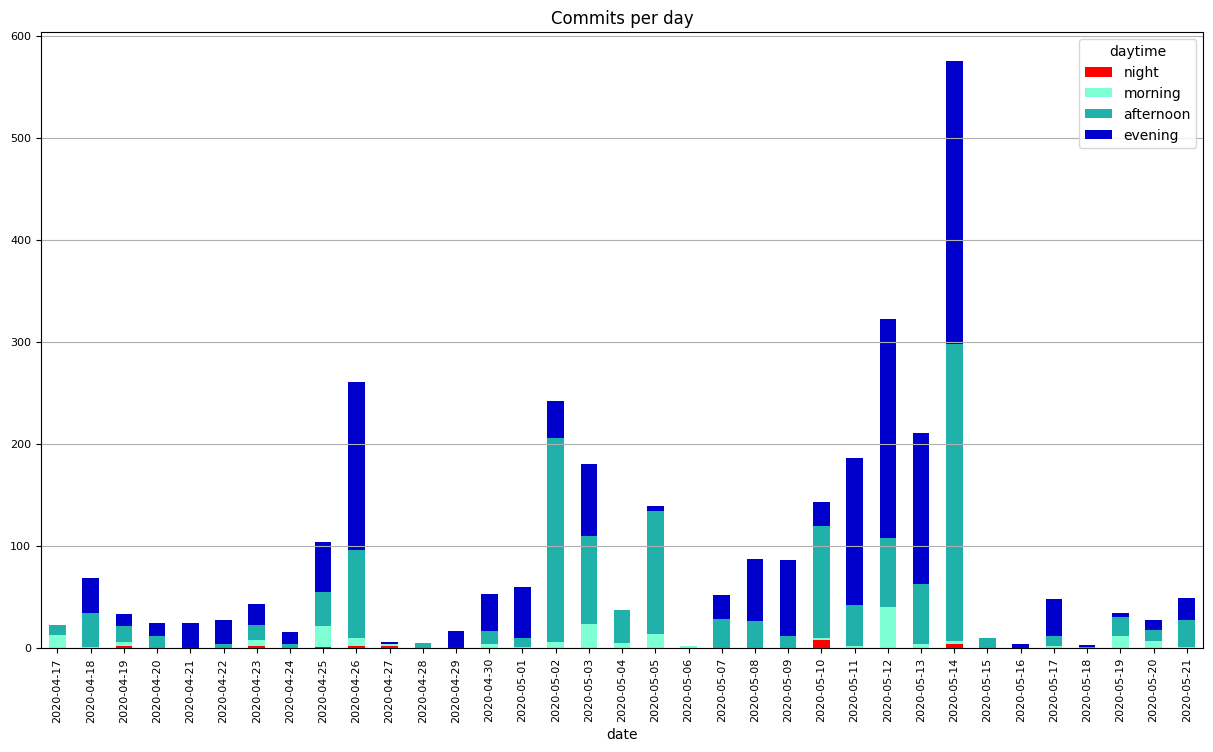

In [15]:
plt = daytime_commits_count.plot(title='Commits per day',
                                 figsize=(15, 8), fontsize=8,
                                 kind='bar', stacked=True,
                                 color=['r', 'aquamarine', 'lightseagreen', 'mediumblue'])
plt.grid(axis='y')

In [16]:
con.close()

---
## Answer the questions

1. When do our users usually commit the labs: in the night, morning, afternoon, or evening?
1. Which day has:
    - the most number of commits
    - and at the same time, the number of commits in the evening is higher than in the afternoon?

The answer is the date of that day.

### Answers
1. `Afternoon` or `evening` is the time users prefered to commit the labs.
2. `2020-05-12` has the `most number of commits` ***and*** `evening commits` are ***more*** than `afternoon` ones. (2 conditions at once)